# 3D Mesh to 2D conversion, using averaged temperaure
### Built on Andrew Ooi's Gauss-Lobatto implementation

In [55]:
import numpy as np
from tqdm import tqdm
from pymech.exadata import exadata, elem
import pandas as pd
import quadpy
from pymech.neksuite import readnek
from pymech.neksuite import writenek
from pymech.dataset import open_dataset

In [56]:
filename='..\Mesh0110_1p50.f00008'
nzplanes=10 # number of macro z planes

In [57]:
data=readnek(filename)

In [58]:
data.lr1

[9, 9, 9]

In [59]:
nel=data.nel
xdata=np.zeros(nel)
ydata=np.zeros(nel)
zdata=np.zeros(nel)
index=np.zeros(nel,dtype=int)

In [60]:
lr1=data.lr1
zaveragedu=np.zeros((lr1[0],lr1[1]))
zaveragedv=np.zeros((lr1[0],lr1[1]))
zaveragedw=np.zeros((lr1[0],lr1[1]))
zaveragedpres=np.zeros((lr1[0],lr1[1]))
zaveragedtemp=np.zeros((lr1[0],lr1[1]))

scheme = quadpy.c1.gauss_lobatto(data.lr1[2])
gausslobattopoints=scheme.points
gausslobattoweights=scheme.weights

xi = gausslobattopoints
w = gausslobattoweights
element_number = np.arange(0,dtype=np.int32)
le = 0

In [61]:
for n in np.arange(nel):
    index[n]=int(n)
    xdata[n]=np.around((data.elem[n].pos[0,0,0,0]+data.elem[n].pos[0,0,0,lr1[0]-1])/2.0,decimals=3)
    ydata[n]=np.around((data.elem[n].pos[1,0,0,0]+data.elem[n].pos[1,0,lr1[0]-1,0])/2.0,decimals=3)
    zdata[n]=np.around((data.elem[n].pos[2,0,0,0]+data.elem[n].pos[2,lr1[0]-1,0,0])/2.0,decimals=3)

# Put data in pandas dataframe then sort the data by x, then y then z.
dataset = pd.DataFrame({'index': index[:],'xval': xdata[:],'yval': ydata[:], 'zval': zdata[:]})
sorteddataset=dataset.sort_values(by=['zval','xval','yval'])

nplanarelements=int(nel/nzplanes)

In [62]:
df2d = sorteddataset.iloc[0:nplanarelements]
df2d['zval'] = df2d['zval'].replace(0.075,0.0)
df2d.reset_index(drop=True, inplace=True)
df2d#.head(15)

,index,xval,yval,zval
0,0,0.168,0.026,0.0
1,149,0.168,0.083,0.0
2,298,0.168,0.151,0.0
3,447,0.168,0.230,0.0
4,596,0.168,0.324,0.0
...,...,...,...,...
1932,1340,49.832,0.902,0.0
1933,1489,49.832,1.125,0.0
1934,1638,49.832,1.375,0.0
1935,1787,49.832,1.625,0.0


In [63]:
#new_2d_data = exadata(2, nplanarelements, [lr1[0],lr1[1],1], [2,2,1,1,2], data.nbc)
new_2d_data = exadata(2, nplanarelements, [1,1,1], [2,2,1,1,2], data.nbc)

In [64]:
df2d.loc[1,'xval']
new_2d_data.elem[0].pos#.shape
#np.array(df2d['xval'].iloc[m])
np.mean(zaveragedu)

0.0

In [69]:
for m in np.arange(nplanarelements):
    zaveragedu[:,:]=0.0
    zaveragedv[:,:]=0.0
    zaveragedw[:,:]=0.0
    zaveragedpres[:,:]=0.0
    zaveragedtemp[:,:]=0.0
    totallengthofz=0.0

    for n in np.arange(nzplanes):
        i=sorteddataset['index'].iloc[m*nzplanes+n]
        a=data.elem[i].pos[2,0,0,0]
        b=data.elem[i].pos[2,data.lr1[2]-1,0,0]
        z=((b-a)/2.0)*xi+(a+b)/2.0
        wprime=w*((b-a)/2.0)

        tempu = np.sum(data.elem[i].vel[0,:,:,:]*wprime[:,np.newaxis,np.newaxis],axis=0)
        totallengthofz += np.sum(wprime)
        zaveragedu += tempu

        tempv = np.sum(data.elem[i].vel[1,:,:,:]*wprime[:,np.newaxis,np.newaxis],axis=0)
        zaveragedv += tempv

        tempw = np.sum(data.elem[i].vel[2,:,:,:]*wprime[:,np.newaxis,np.newaxis],axis=0)
        zaveragedw += tempw

        temppres = np.sum(data.elem[i].pres[0,:,:,:]*wprime[:,np.newaxis,np.newaxis],axis=0)
        zaveragedpres += temppres

        temptemp = np.sum(data.elem[i].temp[0,:,:,:]*wprime[:,np.newaxis,np.newaxis],axis=0)
        zaveragedtemp += temptemp

    zaveragedu /= totallengthofz
    zaveragedv /= totallengthofz
    zaveragedw /= totallengthofz
    zaveragedpres /= totallengthofz
    zaveragedtemp /= totallengthofz

    i = df2d['index'].iloc[13*(m%149) + (m//149)]
    #i = 13*(m%149) + (m//149)
    new_2d_data.elem[i].pos[0,:,:]=df2d['xval'].iloc[m]#np.array(df2d['xval'].iloc[m])#.to_numpy()
    new_2d_data.elem[i].pos[1,:,:]=df2d['yval'].iloc[m]#np.array(df2d['yval'].iloc[m])#.to_numpy()
    new_2d_data.elem[i].pos[2,:,:]=df2d['zval'].iloc[m]#np.array(df2d['zval'].iloc[m])#.to_numpy()
    new_2d_data.elem[i].vel[0,:,:,:]=np.mean(zaveragedu)
    new_2d_data.elem[i].vel[1,:,:,:]=np.mean(zaveragedv)
    new_2d_data.elem[i].vel[2,:,:,:]=np.mean(zaveragedw)
    new_2d_data.elem[i].pres[0,:,:,:]=np.mean(zaveragedpres)
    new_2d_data.elem[i].temp[0,:,:,:]=np.mean(zaveragedtemp)
    # for n in np.arange(nzplanes):
    #     i=sorteddataset['index'].iloc[m*nzplanes+n]
    #     data.elem[i].vel[0,:,:,:]=zaveragedu
    #     data.elem[i].vel[1,:,:,:]=zaveragedv
    #     data.elem[i].vel[2,:,:,:]=zaveragedw
    #     data.elem[i].pres[0,:,:,:]=zaveragedpres
    #     data.elem[i].temp[0,:,:,:]=zaveragedtemp


In [70]:
new_2d_data.wdsz = data.wdsz
new_2d_data.time = data.time
new_2d_data.istep = data.istep
new_2d_data.endian = data.endian
writenek('..\spanwiseavgMesh0110_1p50.f00008',new_2d_data)

0

# Checking if new file is 2D

In [67]:
written_data = readnek('..\spanwiseavgMesh0110_1p50.f00008')
written_data.ndim

2

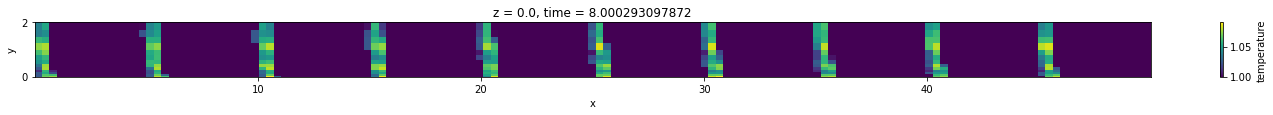

In [71]:
ds = open_dataset("..\spanwiseavgMesh0110_1p50.f00008")
ds.temperature.plot(figsize = (25,1))